In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [ ]:
import os

BASE_DIR = '/content/drive/MyDrive/visual_stream'
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
MODEL_DIR = os.path.join(BASE_DIR, 'model')

DATA_DIR = '/content/dataset'

In [ ]:
!unzip -o '/content/drive/MyDrive/avec2014_preprocessed.zip' -d /content





Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0213.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0216.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0219.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0222.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0225.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0228.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0231.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0234.jpg  
  inflating: /content/dataset/avec14/image/train_Northwind/317_3_Northwind_video_aligned/0237.jpg  
  inflating: /content/dataset/avec14/image/train_

In [ ]:
!ls /content/dataset/avec14


image


In [ ]:
!mv /content/labels_updated.csv /content/dataset/avec14/labels.csv


In [ ]:
!head /content/dataset/avec14/labels.csv

filename,BDI-II
Northwind_Training/203_1_Northwind_video_aligned,3
Freeform_Training/203_1_Freeform_video_aligned,3
Northwind_Training/205_2_Northwind_video_aligned,3
Freeform_Training/205_2_Freeform_video_aligned,3
Northwind_Training/207_2_Northwind_video_aligned,10
Freeform_Training/207_2_Freeform_video_aligned,10
Northwind_Training/208_2_Northwind_video_aligned,4
Freeform_Training/208_2_Freeform_video_aligned,4
Northwind_Training/209_1_Northwind_video_aligned,6


In [ ]:
!mv /content/dataset/avec14/image/train_Northwind /content/dataset/avec14/image/Northwind_Training
!mv /content/dataset/avec14/image/train_Freeform /content/dataset/avec14/image/Freeform_Training
!mv /content/dataset/avec14/image/test_Northwind /content/dataset/avec14/image/Northwind_Testing
!mv /content/dataset/avec14/image/test_Freeform /content/dataset/avec14/image/Freeform_Testing
!mv /content/dataset/avec14/image/dev_Northwind /content/dataset/avec14/image/Northwind_Development
!mv /content/dataset/avec14/image/dev_Freeform /content/dataset/avec14/image/Freeform_Development

In [ ]:
%cd /content


/content


In [ ]:
!pip install torch torchvision torchaudio
!pip install numpy pandas scikit-learn tqdm Pillow
!pip install matplotlib seaborn
!pip install patool

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

### ResNet18 version

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import time
import copy
import random
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

class AVECDataset(Dataset):
    def __init__(self, video_dirs, labels, root_dir, transform=None, sequence_length=64):
        self.video_dirs = video_dirs
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length

        self.video_frame_paths = {}
        for video_dir in self.video_dirs:
            full_path = os.path.join(self.root_dir, video_dir)
            frame_files = sorted([
                os.path.join(full_path, f)
                for f in os.listdir(full_path)
                if f.endswith('.jpg') and f.split('.')[0].isdigit()
            ])
            self.video_frame_paths[video_dir] = frame_files

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        frame_paths = self.video_frame_paths[video_dir]
        label = self.labels[idx]

        if len(frame_paths) > self.sequence_length:
            start_idx = random.randint(0, len(frame_paths) - self.sequence_length)
            selected_paths = frame_paths[start_idx:start_idx + self.sequence_length]
        else:
            selected_paths = frame_paths
            if len(frame_paths) < self.sequence_length:
                padding = [frame_paths[-1]] * (self.sequence_length - len(frame_paths))
                selected_paths = frame_paths + padding

        images = []
        for frame_path in selected_paths:
            image = Image.open(frame_path)
            if self.transform:
                image = self.transform(image)
            images.append(image)

        images = torch.stack(images)
        label = torch.tensor(label, dtype=torch.float32)

        return images, label

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

csv_file = '/content/dataset/avec14/labels.csv'
root_dir = '/content/dataset/avec14/image/'

full_df = pd.read_csv(csv_file)
train_val_df = full_df.iloc[:200]
test_df = full_df.iloc[-100:]

train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_dataset = AVECDataset(
    video_dirs=train_df['filename'].tolist(),
    labels=train_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['train']
)

val_dataset = AVECDataset(
    video_dirs=val_df['filename'].tolist(),
    labels=val_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)

test_dataset = AVECDataset(
    video_dirs=test_df['filename'].tolist(),
    labels=test_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

class VisualStreamModel(nn.Module):
    def __init__(self):
        super(VisualStreamModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.resnet_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        output = self.mlp(last_out)
        return output.squeeze()

model = VisualStreamModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = float('inf')
    best_rmse = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_mae = 0.0
            running_rmse = 0.0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                mae = torch.mean(torch.abs(outputs - labels))
                rmse = torch.sqrt(torch.mean((outputs - labels)**2))
                running_mae += mae.item() * inputs.size(0)
                running_rmse += rmse.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_mae = running_mae / len(dataloader.dataset)
            epoch_rmse = running_rmse / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f} RMSE: {epoch_rmse:.4f}')

            if phase == 'val' and (epoch + 1) % 5 == 0:
                checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'mae': epoch_mae,
                    'rmse': epoch_rmse,
                }, checkpoint_path)
                print(f"Checkpoint saved at epoch {epoch}")

            if phase == 'val' and epoch_mae < best_mae:
                best_mae = epoch_mae
                best_rmse = epoch_rmse
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_path = os.path.join(MODEL_DIR, 'best_model_mae.pth')
                torch.save(model.state_dict(), best_model_path)
                print(f"New best model saved with MAE: {best_mae:.4f}, RMSE: {best_rmse:.4f}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val MAE: {best_mae:.4f}, Best val RMSE: {best_rmse:.4f}')

    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=100)

final_model_path = os.path.join(MODEL_DIR, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)

print("\nModel Workflow Explanation:")
print("1. Input: Batch of video sequences (shape: [batch_size, 64, 3, 224, 224])")
print("2. ResNet18: Processes each frame individually (output: [batch_size*64, 512, 7, 7])")
print("3. Global Average Pooling: Reduces each frame to [512] features")
print("4. Reshape: [batch_size, 64, 512] for temporal processing")
print("5. BiLSTM: Processes temporal sequence (output: [batch_size, 64, 512])")
print("6. Last Frame Selection: Takes final LSTM output [batch_size, 512]")
print("7. MLP: Reduces to final prediction [batch_size, 1]")
print("8. Output: Predicted BDI-II score (0-63 range)")

print("\nKey Parameters:")
print(f"- Sequence length: 64 frames")
print(f"- ResNet18 output features: 512")
print(f"- LSTM hidden size: 256 (512 with bidirectional)")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: 0.001")
print(f"- Dropout: 0.5 in MLP")

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 197.2302 MAE: 10.7958 RMSE: 13.1739


val: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


val Loss: 127.8717 MAE: 9.4766 RMSE: 10.5529
New best model saved with MAE: 9.4766, RMSE: 10.5529

Epoch 1/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 160.0951 MAE: 10.6818 RMSE: 12.0271


val: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


val Loss: 128.5744 MAE: 9.4500 RMSE: 10.4911
New best model saved with MAE: 9.4500, RMSE: 10.4911

Epoch 2/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 161.2931 MAE: 10.8681 RMSE: 12.3309


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 143.3502 MAE: 9.6375 RMSE: 10.8556

Epoch 3/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 160.0848 MAE: 10.4793 RMSE: 11.8679


val: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


val Loss: 130.0766 MAE: 9.4427 RMSE: 10.4835
New best model saved with MAE: 9.4427, RMSE: 10.4835

Epoch 4/99
----------


train: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


train Loss: 160.5533 MAE: 10.6721 RMSE: 12.2369


val: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 137.2045 MAE: 9.5365 RMSE: 10.6570
Checkpoint saved at epoch 4

Epoch 5/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 172.7876 MAE: 11.1176 RMSE: 12.5781


val: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


val Loss: 133.5625 MAE: 9.4860 RMSE: 10.5677

Epoch 6/99
----------


train: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


train Loss: 158.5386 MAE: 10.5769 RMSE: 12.0366


val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


val Loss: 139.1251 MAE: 9.5937 RMSE: 10.7351

Epoch 7/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 152.9799 MAE: 10.3849 RMSE: 11.9035


val: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 128.0663 MAE: 9.4594 RMSE: 10.4610

Epoch 8/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 151.3351 MAE: 10.2039 RMSE: 11.7922


val: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


val Loss: 122.8850 MAE: 9.2071 RMSE: 10.3108
New best model saved with MAE: 9.2071, RMSE: 10.3108

Epoch 9/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


train Loss: 157.2668 MAE: 10.2105 RMSE: 11.9906


val: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 129.0161 MAE: 9.5619 RMSE: 10.6696
Checkpoint saved at epoch 9

Epoch 10/99
----------


train: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]


train Loss: 146.8460 MAE: 10.1506 RMSE: 11.4965


val: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 127.3658 MAE: 8.7561 RMSE: 10.2759
New best model saved with MAE: 8.7561, RMSE: 10.2759

Epoch 11/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


train Loss: 160.8870 MAE: 10.4501 RMSE: 12.0373


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 111.0433 MAE: 8.4898 RMSE: 9.5086
New best model saved with MAE: 8.4898, RMSE: 9.5086

Epoch 12/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 151.3768 MAE: 10.2679 RMSE: 11.7222


val: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


val Loss: 119.5073 MAE: 8.7541 RMSE: 9.8135

Epoch 13/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


train Loss: 151.5254 MAE: 10.2120 RMSE: 11.7909


val: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 129.3956 MAE: 9.4022 RMSE: 10.5154

Epoch 14/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 160.7527 MAE: 10.6804 RMSE: 12.2055


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 135.6099 MAE: 9.5253 RMSE: 10.6546
Checkpoint saved at epoch 14

Epoch 15/99
----------


train: 100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


train Loss: 157.4571 MAE: 10.2987 RMSE: 12.0102


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 132.4296 MAE: 9.3954 RMSE: 10.5156

Epoch 16/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 161.3682 MAE: 10.5910 RMSE: 12.1846


val: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 140.2904 MAE: 9.5570 RMSE: 10.8088

Epoch 17/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 157.4329 MAE: 10.4595 RMSE: 12.1098


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 117.3271 MAE: 8.8473 RMSE: 9.9269

Epoch 18/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 155.5482 MAE: 10.2569 RMSE: 11.7731


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 113.0507 MAE: 8.9157 RMSE: 9.8927

Epoch 19/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 159.7803 MAE: 10.6723 RMSE: 12.1605


val: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


val Loss: 122.9135 MAE: 9.0482 RMSE: 10.2084
Checkpoint saved at epoch 19

Epoch 20/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 148.9646 MAE: 10.3409 RMSE: 11.6938


val: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


val Loss: 113.2303 MAE: 8.8062 RMSE: 9.9689

Epoch 21/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 156.0271 MAE: 10.2736 RMSE: 11.7826


val: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 139.1856 MAE: 9.5144 RMSE: 10.7667

Epoch 22/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 157.0315 MAE: 10.5272 RMSE: 12.0451


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 135.7963 MAE: 9.4881 RMSE: 10.6768

Epoch 23/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 156.4437 MAE: 10.4340 RMSE: 11.9719


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 132.0932 MAE: 9.3509 RMSE: 10.4628

Epoch 24/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


train Loss: 166.7000 MAE: 11.0058 RMSE: 12.3198


val: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 134.3008 MAE: 9.5112 RMSE: 10.5944
Checkpoint saved at epoch 24

Epoch 25/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 155.6317 MAE: 10.5939 RMSE: 11.9295


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 134.2672 MAE: 9.5104 RMSE: 10.5935

Epoch 26/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 163.7885 MAE: 10.5494 RMSE: 12.2851


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 129.3250 MAE: 9.4500 RMSE: 10.4894

Epoch 27/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 166.2381 MAE: 10.8472 RMSE: 12.3975


val: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 144.9118 MAE: 9.6713 RMSE: 10.9146

Epoch 28/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 162.7478 MAE: 10.6719 RMSE: 12.2263


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 133.7661 MAE: 9.5001 RMSE: 10.5800

Epoch 29/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 165.3589 MAE: 10.9039 RMSE: 12.3495


val: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 134.8854 MAE: 9.5227 RMSE: 10.6108
Checkpoint saved at epoch 29

Epoch 30/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 164.7641 MAE: 10.8974 RMSE: 12.2407


val: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


val Loss: 129.9342 MAE: 9.4495 RMSE: 10.4954

Epoch 31/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 154.6939 MAE: 10.4992 RMSE: 11.8030


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 133.8733 MAE: 9.5028 RMSE: 10.5836

Epoch 32/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 164.9184 MAE: 10.7012 RMSE: 12.0335


val: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 132.0096 MAE: 9.4893 RMSE: 10.5467

Epoch 33/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 166.3317 MAE: 10.8252 RMSE: 12.3177


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 145.4373 MAE: 9.6691 RMSE: 10.9357

Epoch 34/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 153.2253 MAE: 10.2507 RMSE: 11.7272


val: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 129.4893 MAE: 9.4398 RMSE: 10.4857
Checkpoint saved at epoch 34

Epoch 35/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 155.1321 MAE: 10.4321 RMSE: 11.8572


val: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


val Loss: 135.4708 MAE: 9.5511 RMSE: 10.6775

Epoch 36/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 157.8622 MAE: 10.4831 RMSE: 11.8079


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 128.4147 MAE: 9.4358 RMSE: 10.4666

Epoch 37/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 155.7262 MAE: 10.4594 RMSE: 12.0442


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 128.5428 MAE: 9.3671 RMSE: 10.3943

Epoch 38/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 163.9814 MAE: 10.7464 RMSE: 12.1177


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 129.0805 MAE: 9.5115 RMSE: 10.5467

Epoch 39/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 149.8594 MAE: 10.5325 RMSE: 11.7911


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 118.9403 MAE: 8.8608 RMSE: 9.9322
Checkpoint saved at epoch 39

Epoch 40/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


train Loss: 159.5499 MAE: 10.5329 RMSE: 12.0725


val: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


val Loss: 120.3631 MAE: 8.9001 RMSE: 9.9671

Epoch 41/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 154.8062 MAE: 10.1264 RMSE: 11.6410


val: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


val Loss: 116.9612 MAE: 8.8900 RMSE: 9.9770

Epoch 42/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 162.1493 MAE: 10.7668 RMSE: 12.2757


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 127.6090 MAE: 8.9213 RMSE: 10.1208

Epoch 43/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 159.8429 MAE: 10.5393 RMSE: 12.0653


val: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 109.0194 MAE: 8.4353 RMSE: 9.4548
New best model saved with MAE: 8.4353, RMSE: 9.4548

Epoch 44/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 164.2395 MAE: 10.7821 RMSE: 12.2706


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 126.1735 MAE: 8.8627 RMSE: 10.0943
Checkpoint saved at epoch 44

Epoch 45/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


train Loss: 155.8141 MAE: 10.4305 RMSE: 11.8654


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 126.0385 MAE: 9.0701 RMSE: 10.2373

Epoch 46/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 149.4963 MAE: 10.1914 RMSE: 11.7944


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 115.2012 MAE: 8.7221 RMSE: 9.8457

Epoch 47/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 147.4495 MAE: 9.9045 RMSE: 11.5136


val: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


val Loss: 138.8788 MAE: 9.3021 RMSE: 10.7310

Epoch 48/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 175.1542 MAE: 11.0521 RMSE: 12.5158


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 129.1808 MAE: 9.2457 RMSE: 10.4014

Epoch 49/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 157.9125 MAE: 10.5260 RMSE: 12.0792


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 129.7747 MAE: 9.2330 RMSE: 10.3671
Checkpoint saved at epoch 49

Epoch 50/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 154.8869 MAE: 10.2599 RMSE: 11.8772


val: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


val Loss: 120.7229 MAE: 8.9943 RMSE: 10.1508

Epoch 51/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 149.7373 MAE: 9.9946 RMSE: 11.4991


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 116.7599 MAE: 8.7942 RMSE: 9.9400

Epoch 52/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 164.4599 MAE: 10.6634 RMSE: 12.1121


val: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 124.5821 MAE: 9.0677 RMSE: 10.1538

Epoch 53/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 155.3997 MAE: 10.6229 RMSE: 12.0069


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 149.0915 MAE: 9.7026 RMSE: 11.0256

Epoch 54/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 149.0018 MAE: 10.3150 RMSE: 11.6879


val: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 119.8202 MAE: 9.0343 RMSE: 10.0352
Checkpoint saved at epoch 54

Epoch 55/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 132.0880 MAE: 9.4903 RMSE: 10.8611


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 97.6139 MAE: 8.0490 RMSE: 9.0441
New best model saved with MAE: 8.0490, RMSE: 9.0441

Epoch 56/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


train Loss: 143.1987 MAE: 9.7027 RMSE: 11.3457


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 94.6695 MAE: 7.8687 RMSE: 9.0987
New best model saved with MAE: 7.8687, RMSE: 9.0987

Epoch 57/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]


train Loss: 164.2168 MAE: 10.6100 RMSE: 12.1834


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 108.5198 MAE: 8.3428 RMSE: 9.4274

Epoch 58/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 145.9589 MAE: 10.0200 RMSE: 11.4125


val: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 114.5892 MAE: 8.7375 RMSE: 9.9462

Epoch 59/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 134.1449 MAE: 9.7984 RMSE: 11.0765


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 101.3945 MAE: 8.3740 RMSE: 9.4556
Checkpoint saved at epoch 59

Epoch 60/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


train Loss: 143.2931 MAE: 9.6613 RMSE: 11.2441


val: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


val Loss: 114.4611 MAE: 8.6131 RMSE: 9.9917

Epoch 61/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 130.3025 MAE: 9.1356 RMSE: 10.6244


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 102.0706 MAE: 8.4011 RMSE: 9.5241

Epoch 62/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 138.2882 MAE: 9.7133 RMSE: 11.2529


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 95.9910 MAE: 8.1181 RMSE: 9.2635

Epoch 63/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 140.6007 MAE: 9.7339 RMSE: 11.4486


val: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 103.8199 MAE: 8.4373 RMSE: 9.4489

Epoch 64/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 151.8583 MAE: 10.2363 RMSE: 11.6661


val: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


val Loss: 106.0365 MAE: 8.6636 RMSE: 9.6665
Checkpoint saved at epoch 64

Epoch 65/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 151.5725 MAE: 10.2102 RMSE: 11.7796


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 125.2120 MAE: 9.1789 RMSE: 10.3840

Epoch 66/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 141.3505 MAE: 9.9460 RMSE: 11.2360


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 118.1586 MAE: 8.9688 RMSE: 10.0143

Epoch 67/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 146.7003 MAE: 10.0608 RMSE: 11.6838


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 118.9334 MAE: 8.9524 RMSE: 10.0391

Epoch 68/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 140.1409 MAE: 9.5824 RMSE: 11.3166


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 112.8752 MAE: 8.7614 RMSE: 9.9614

Epoch 69/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 133.0226 MAE: 9.6267 RMSE: 11.1365


val: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 97.9442 MAE: 8.3177 RMSE: 9.3998
Checkpoint saved at epoch 69

Epoch 70/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 135.8375 MAE: 9.7105 RMSE: 11.1490


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 106.5919 MAE: 8.2563 RMSE: 9.6418

Epoch 71/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 151.0120 MAE: 10.3762 RMSE: 11.8327


val: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


val Loss: 123.0019 MAE: 9.0706 RMSE: 10.3123

Epoch 72/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 133.4646 MAE: 9.5310 RMSE: 11.0001


val: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 111.5932 MAE: 8.6814 RMSE: 9.7483

Epoch 73/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 146.6189 MAE: 9.7761 RMSE: 11.4090


val: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


val Loss: 104.7637 MAE: 8.4440 RMSE: 9.7003

Epoch 74/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 134.6777 MAE: 9.6865 RMSE: 11.0846


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 114.8079 MAE: 8.8118 RMSE: 9.9318
Checkpoint saved at epoch 74

Epoch 75/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 142.4553 MAE: 9.9528 RMSE: 11.2268


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 133.9530 MAE: 9.2074 RMSE: 10.5210

Epoch 76/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 129.8011 MAE: 9.3774 RMSE: 10.7696


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 105.4345 MAE: 8.6118 RMSE: 9.6169

Epoch 77/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 153.0828 MAE: 10.4511 RMSE: 11.8509


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 112.5490 MAE: 8.4917 RMSE: 9.6265

Epoch 78/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 124.5177 MAE: 9.0316 RMSE: 10.5132


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 115.0595 MAE: 9.0537 RMSE: 10.4234

Epoch 79/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 130.9864 MAE: 9.4199 RMSE: 10.9219


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 108.6617 MAE: 8.3410 RMSE: 9.7874
Checkpoint saved at epoch 79

Epoch 80/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 125.5641 MAE: 9.3008 RMSE: 10.5673


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 91.0787 MAE: 7.4727 RMSE: 8.9896
New best model saved with MAE: 7.4727, RMSE: 8.9896

Epoch 81/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


train Loss: 110.3525 MAE: 8.3243 RMSE: 9.9631


val: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 92.3143 MAE: 7.9963 RMSE: 9.2030

Epoch 82/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 121.9374 MAE: 9.0060 RMSE: 10.5381


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 105.7068 MAE: 8.7138 RMSE: 9.8519

Epoch 83/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 138.8406 MAE: 9.3215 RMSE: 11.0744


val: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


val Loss: 92.6449 MAE: 8.2759 RMSE: 9.2229

Epoch 84/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 122.3687 MAE: 9.0837 RMSE: 10.5567


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 83.0461 MAE: 7.6995 RMSE: 8.7660
Checkpoint saved at epoch 84

Epoch 85/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 143.2117 MAE: 9.8466 RMSE: 11.3794


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 93.8849 MAE: 8.1026 RMSE: 9.2991

Epoch 86/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 132.2155 MAE: 9.3014 RMSE: 10.8999


val: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


val Loss: 109.2441 MAE: 8.3624 RMSE: 9.9505

Epoch 87/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


train Loss: 126.4450 MAE: 8.8404 RMSE: 10.5080


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 91.8342 MAE: 7.7624 RMSE: 9.0317

Epoch 88/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 122.2322 MAE: 8.9684 RMSE: 10.6003


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 111.8276 MAE: 8.4406 RMSE: 9.9160

Epoch 89/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 130.3558 MAE: 9.4995 RMSE: 10.8207


val: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 112.1020 MAE: 8.4874 RMSE: 9.9504
Checkpoint saved at epoch 89

Epoch 90/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 122.4049 MAE: 8.9811 RMSE: 10.4285


val: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


val Loss: 102.4511 MAE: 7.9896 RMSE: 9.8201

Epoch 91/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 119.9978 MAE: 9.1513 RMSE: 10.4537


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 120.1291 MAE: 8.7189 RMSE: 9.9597

Epoch 92/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


train Loss: 133.2911 MAE: 9.1241 RMSE: 10.8873


val: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 111.8342 MAE: 8.4892 RMSE: 9.8051

Epoch 93/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 124.7116 MAE: 9.2942 RMSE: 10.7878


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 114.6240 MAE: 8.3854 RMSE: 9.8600

Epoch 94/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 122.4214 MAE: 8.9083 RMSE: 10.4289


val: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


val Loss: 105.1745 MAE: 8.4187 RMSE: 9.7919
Checkpoint saved at epoch 94

Epoch 95/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 133.6479 MAE: 9.1208 RMSE: 10.8971


val: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 89.8181 MAE: 7.8928 RMSE: 9.2158

Epoch 96/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 120.8396 MAE: 8.9928 RMSE: 10.4118


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 92.2684 MAE: 8.0007 RMSE: 9.2340

Epoch 97/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 123.7541 MAE: 8.9494 RMSE: 10.6365


val: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


val Loss: 106.3296 MAE: 8.8078 RMSE: 9.9445

Epoch 98/99
----------


train: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


train Loss: 127.9982 MAE: 9.3334 RMSE: 10.7749


val: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 111.1025 MAE: 8.5121 RMSE: 9.9037

Epoch 99/99
----------


train: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


train Loss: 118.4784 MAE: 8.8670 RMSE: 10.2715


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 105.6468 MAE: 8.3175 RMSE: 9.7378
Checkpoint saved at epoch 99

Training complete in 82m 57s
Best val MAE: 7.4727, Best val RMSE: 8.9896

Model Workflow Explanation:
1. Input: Batch of video sequences (shape: [batch_size, 64, 3, 224, 224])
2. ResNet18: Processes each frame individually (output: [batch_size*64, 512, 7, 7])
3. Global Average Pooling: Reduces each frame to [512] features
4. Reshape: [batch_size, 64, 512] for temporal processing
5. BiLSTM: Processes temporal sequence (output: [batch_size, 64, 512])
6. Last Frame Selection: Takes final LSTM output [batch_size, 512]
7. MLP: Reduces to final prediction [batch_size, 1]
8. Output: Predicted BDI-II score (0-63 range)

Key Parameters:
- Sequence length: 64 frames
- ResNet18 output features: 512
- LSTM hidden size: 256 (512 with bidirectional)
- Batch size: 4
- Learning rate: 0.001
- Dropout: 0.5 in MLP


Loaded best model based on validation MAE
Testing on 100 samples


Testing: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]



Test Results:
MAE: 8.4306
RMSE: 10.8404
R² Score: 0.1084

Saved detailed results to: /content/drive/MyDrive/visual_stream/test_results.csv
Saved visualization to: /content/drive/MyDrive/visual_stream/test_results.png


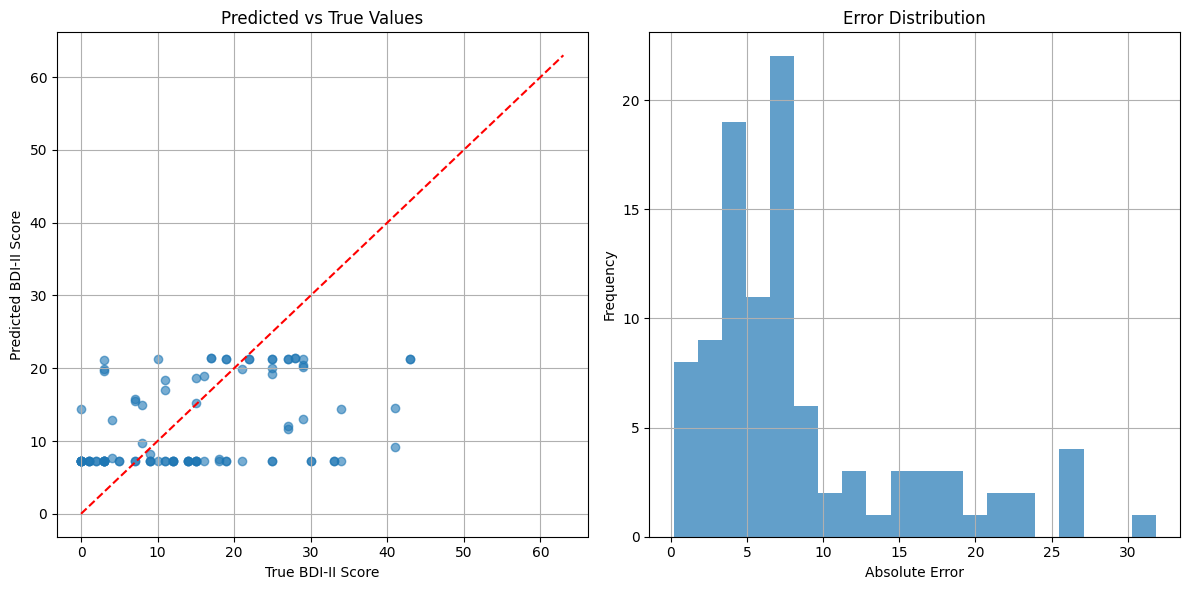


Sample Predictions:
File: Freeform_Testing/345_3_Freeform_video_aligned
  True: 0.0, Predicted: 7.2, Error: 7.2
File: Freeform_Testing/310_2_Freeform_video_aligned
  True: 19.0, Predicted: 7.2, Error: 11.8
File: Northwind_Testing/338_1_Northwind_video_aligned
  True: 12.0, Predicted: 7.2, Error: 4.8
File: Freeform_Testing/247_1_Freeform_video_aligned
  True: 14.0, Predicted: 7.3, Error: 6.7
File: Northwind_Testing/247_1_Northwind_video_aligned
  True: 14.0, Predicted: 7.2, Error: 6.8


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_path = os.path.join(MODEL_DIR, 'best_model_mae.pth')
model = VisualStreamModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Loaded best model based on validation MAE")

print(f"Testing on {len(test_dataset)} samples")

def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = evaluate_model(model, test_loader)

mae = mean_absolute_error(true_labels, predictions)
rmse = np.sqrt(mean_squared_error(true_labels, predictions))
r2 = 1 - (np.sum((true_labels - predictions)**2) /
          np.sum((true_labels - np.mean(true_labels))**2))

print("\nTest Results:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

results_df = pd.DataFrame({
    'Filename': test_df['filename'],
    'True_BDI': true_labels,
    'Predicted_BDI': predictions,
    'Absolute_Error': np.abs(true_labels - predictions)
})
results_csv_path = os.path.join(BASE_DIR, 'test_results.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"\nSaved detailed results to: {results_csv_path}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(true_labels, predictions, alpha=0.6)
plt.plot([0, 63], [0, 63], 'r--')
plt.xlabel('True BDI-II Score')
plt.ylabel('Predicted BDI-II Score')
plt.title('Predicted vs True Values')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(results_df['Absolute_Error'], bins=20, alpha=0.7)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(BASE_DIR, 'test_results.png')
plt.savefig(plot_path)
print(f"Saved visualization to: {plot_path}")
plt.show()

print("\nSample Predictions:")
sample_results = results_df.sample(5, random_state=42)
for _, row in sample_results.iterrows():
    print(f"File: {row['Filename']}")
    print(f"  True: {row['True_BDI']:.1f}, Predicted: {row['Predicted_BDI']:.1f}, Error: {row['Absolute_Error']:.1f}")

### ResNet34 version

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import time
import copy
import random
from tqdm import tqdm
import torch.nn.functional as F
import torch.cuda
import torch.cuda.amp


torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

class AVECDataset(Dataset):
    def __init__(self, video_dirs, labels, root_dir, transform=None, sequence_length=64):
        self.video_dirs = video_dirs
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length

        self.video_frame_paths = {}
        for video_dir in self.video_dirs:
            full_path = os.path.join(self.root_dir, video_dir)
            frame_files = sorted([
                os.path.join(full_path, f)
                for f in os.listdir(full_path)
                if f.endswith('.jpg') and f.split('.')[0].isdigit()
            ])
            self.video_frame_paths[video_dir] = frame_files

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        frame_paths = self.video_frame_paths[video_dir]
        label = self.labels[idx]

        if len(frame_paths) > self.sequence_length:
            start_idx = random.randint(0, len(frame_paths) - self.sequence_length)
            selected_paths = frame_paths[start_idx:start_idx + self.sequence_length]
        else:
            selected_paths = frame_paths
            if len(frame_paths) < self.sequence_length:
                padding = [frame_paths[-1]] * (self.sequence_length - len(frame_paths))
                selected_paths = frame_paths + padding

        images = []
        for frame_path in selected_paths:
            image = Image.open(frame_path)
            if self.transform:
                image = self.transform(image)
            images.append(image)

        images = torch.stack(images)
        label = torch.tensor(label, dtype=torch.float32)

        return images, label

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

csv_file = '/content/dataset/avec14/labels.csv'
root_dir = '/content/dataset/avec14/image/'

full_df = pd.read_csv(csv_file)
train_val_df = full_df.iloc[:200]
test_df = full_df.iloc[-100:]

train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_dataset = AVECDataset(
    video_dirs=train_df['filename'].tolist(),
    labels=train_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['train']
)

val_dataset = AVECDataset(
    video_dirs=val_df['filename'].tolist(),
    labels=val_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)

test_dataset = AVECDataset(
    video_dirs=test_df['filename'].tolist(),
    labels=test_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

class EnhancedVisualStream(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = models.resnet34(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.2
        )

        self.attention = nn.Sequential(
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        batch_size, seq_len = x.shape[:2]

        x = x.view(-1, *x.shape[2:])
        features = self.feature_extractor(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(batch_size, seq_len, -1)

        lstm_out, _ = self.lstm(features)

        attn_weights = self.attention(lstm_out)
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)

        mean_pool = torch.mean(lstm_out, dim=1)

        combined = torch.cat([attn_applied, mean_pool], dim=1)

        output = self.mlp(combined)
        return output.squeeze()

model = EnhancedVisualStream().to(device)

criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

def train_model(model, criterion, optimizer, scheduler, num_epochs=80, start_epoch=0):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = float('inf')
    best_rmse = float('inf')

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_mae = 0.0
            running_rmse = 0.0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                mae = torch.mean(torch.abs(outputs - labels))
                rmse = torch.sqrt(torch.mean((outputs - labels)**2))
                running_mae += mae.item() * inputs.size(0)
                running_rmse += rmse.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_mae = running_mae / len(dataloader.dataset)
            epoch_rmse = running_rmse / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f} RMSE: {epoch_rmse:.4f}')

            if phase == 'val':
                scheduler.step(epoch_mae)

                if (epoch + 1) % 10 == 0:
                    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth')
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': epoch_loss,
                        'mae': epoch_mae,
                        'rmse': epoch_rmse,
                    }, checkpoint_path)
                    print(f"Checkpoint saved at epoch {epoch+1}")

                if epoch_mae < best_mae:
                    best_mae = epoch_mae
                    best_rmse = epoch_rmse
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_model_path = os.path.join(MODEL_DIR, 'best_model_mae.pth')
                    torch.save(model.state_dict(), best_model_path)
                    print(f"New best model! MAE: {best_mae:.4f}, RMSE: {best_rmse:.4f}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val MAE: {best_mae:.4f}, Best val RMSE: {best_rmse:.4f}')

    model.load_state_dict(best_model_wts)
    return model

torch.cuda.empty_cache()

checkpoint_path = os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_159.pth')

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")
    start_epoch = 0
model = train_model(model, criterion, optimizer, scheduler, num_epochs=200, start_epoch=start_epoch)

final_model_path = os.path.join(MODEL_DIR, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)

print("\nEnhanced Model Workflow:")
print("1. Input: Batch of sequences [B, 64, 3, 224, 224]")
print("2. ResNet34: Extract frame features [B×64, 512, 1, 1]")
print("3. BiLSTM: Process temporal sequence [B, 64, 512]")
print("4. Attention: Weight important frames [B, 64, 1] → [B, 512]")
print("5. Mean Pooling: Global temporal context [B, 512]")
print("6. Concatenate: Attention + Mean features [B, 1024]")
print("7. MLP: Final prediction [B, 1]")

print("\nEnhanced Parameters:")
print(f"- Backbone: ResNet34 (vs original ResNet18)")
print(f"- LSTM: 2 layers, 256 hidden (512 bidirectional)")
print(f"- Attention: 128-unit hidden layer")
print(f"- MLP: 1024→512→256→1 with BatchNorm")
print(f"- Loss: Huber (δ=1.0) + AdamW optimizer")
print(f"- Batch size: {batch_size} (adjust if memory limited)")
print(f"- Initial LR: 0.0003 with ReduceLROnPlateau")

/tmp/ipython-input-12-864226685.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 122MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Loading checkpoint from /content/drive/MyDrive/visual_stream/checkpoints/checkpoint_epoch_89.pth
Resuming training from epoch 90
Epoch 91/200
----------


train: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


train Loss: 6.5052 MAE: 6.9878 RMSE: 8.5842


val: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


val Loss: 7.3271 MAE: 7.7838 RMSE: 9.8917
New best model! MAE: 7.7838, RMSE: 9.8917

Epoch 92/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 7.1792 MAE: 7.6603 RMSE: 9.6638


val: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


val Loss: 7.9182 MAE: 8.4155 RMSE: 10.2904

Epoch 93/200
----------


train: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


train Loss: 6.6630 MAE: 7.1454 RMSE: 8.7387


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 8.5455 MAE: 9.0325 RMSE: 11.3609

Epoch 94/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 7.5208 MAE: 8.0121 RMSE: 9.8474


val: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


val Loss: 7.9603 MAE: 8.4283 RMSE: 10.3474

Epoch 95/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.9862 MAE: 7.4747 RMSE: 9.0657


val: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


val Loss: 8.4580 MAE: 8.9260 RMSE: 10.9623

Epoch 96/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.3915 MAE: 6.8689 RMSE: 8.4954


val: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


val Loss: 8.5481 MAE: 9.0341 RMSE: 11.2388

Epoch 97/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.5307 MAE: 7.0166 RMSE: 8.4336


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.8621 MAE: 8.3448 RMSE: 10.1479

Epoch 98/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.8998 MAE: 7.3774 RMSE: 9.1758


val: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


val Loss: 8.4303 MAE: 8.9197 RMSE: 11.0155

Epoch 99/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 6.8313 MAE: 7.3174 RMSE: 8.8945


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.6680 MAE: 8.1399 RMSE: 10.0750

Epoch 100/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.0886 MAE: 7.5647 RMSE: 9.4089


val: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


val Loss: 7.6610 MAE: 8.1394 RMSE: 9.8156
Checkpoint saved at epoch 100

Epoch 101/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


train Loss: 6.8970 MAE: 7.3864 RMSE: 8.6761


val: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


val Loss: 7.6831 MAE: 8.1615 RMSE: 10.0997

Epoch 102/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.3089 MAE: 7.7860 RMSE: 9.7381


val: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


val Loss: 8.4238 MAE: 8.8887 RMSE: 11.0473

Epoch 103/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 7.2913 MAE: 7.7784 RMSE: 9.3546


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.9542 MAE: 8.4334 RMSE: 10.6455

Epoch 104/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.7912 MAE: 7.2735 RMSE: 8.9218


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 7.9796 MAE: 8.4641 RMSE: 10.4022

Epoch 105/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.5789 MAE: 7.0615 RMSE: 8.7406


val: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


val Loss: 7.8111 MAE: 8.2962 RMSE: 10.3310

Epoch 106/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.6634 MAE: 7.1533 RMSE: 8.7741


val: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


val Loss: 8.7114 MAE: 9.2010 RMSE: 11.2921

Epoch 107/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.2711 MAE: 6.7523 RMSE: 8.3476


val: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


val Loss: 7.8875 MAE: 8.3649 RMSE: 10.6613

Epoch 108/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 5.5764 MAE: 6.0526 RMSE: 7.4754


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 8.2722 MAE: 8.7578 RMSE: 10.6945

Epoch 109/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.2579 MAE: 7.7356 RMSE: 9.6314


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 7.6827 MAE: 8.1439 RMSE: 9.9223

Epoch 110/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 6.7556 MAE: 7.2410 RMSE: 8.6810


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 9.0603 MAE: 9.5471 RMSE: 11.5559
Checkpoint saved at epoch 110

Epoch 111/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.7395 MAE: 7.2265 RMSE: 8.9751


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.5034 MAE: 7.9801 RMSE: 9.7962

Epoch 112/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.5168 MAE: 7.0046 RMSE: 8.5662


val: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


val Loss: 8.8974 MAE: 9.3760 RMSE: 11.4205

Epoch 113/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


train Loss: 7.0783 MAE: 7.5588 RMSE: 9.3474


val: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


val Loss: 7.9884 MAE: 8.4707 RMSE: 10.3513

Epoch 114/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.4499 MAE: 7.9272 RMSE: 9.6391


val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


val Loss: 7.8465 MAE: 8.3241 RMSE: 10.3430

Epoch 115/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.7652 MAE: 7.2515 RMSE: 8.8707


val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


val Loss: 8.2196 MAE: 8.6988 RMSE: 10.5128

Epoch 116/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 7.2019 MAE: 7.6876 RMSE: 9.4732


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 7.5452 MAE: 8.0113 RMSE: 9.9681

Epoch 117/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.0923 MAE: 6.5652 RMSE: 8.2765


val: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


val Loss: 7.4159 MAE: 7.8915 RMSE: 10.0033

Epoch 118/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 6.5156 MAE: 6.9979 RMSE: 8.4523


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 8.5142 MAE: 8.9865 RMSE: 11.1502

Epoch 119/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.0142 MAE: 7.5015 RMSE: 9.1284


val: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


val Loss: 7.7217 MAE: 8.2014 RMSE: 10.1062

Epoch 120/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.3845 MAE: 6.8697 RMSE: 8.3206


val: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


val Loss: 7.0893 MAE: 7.5430 RMSE: 9.9925
Checkpoint saved at epoch 120
New best model! MAE: 7.5430, RMSE: 9.9925

Epoch 121/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


train Loss: 6.7641 MAE: 7.2486 RMSE: 8.8120


val: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


val Loss: 7.6333 MAE: 8.1109 RMSE: 9.8876

Epoch 122/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.9424 MAE: 7.4271 RMSE: 9.0760


val: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


val Loss: 7.9061 MAE: 8.3802 RMSE: 10.1839

Epoch 123/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 7.4216 MAE: 7.9143 RMSE: 9.4841


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 8.0254 MAE: 8.4899 RMSE: 10.7804

Epoch 124/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.4680 MAE: 7.9532 RMSE: 9.8405


val: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


val Loss: 8.1272 MAE: 8.6115 RMSE: 10.7157

Epoch 125/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 7.3925 MAE: 7.8712 RMSE: 9.5448


val: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


val Loss: 8.6631 MAE: 9.1546 RMSE: 11.3011

Epoch 126/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 7.0729 MAE: 7.5500 RMSE: 9.1885


val: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


val Loss: 8.6321 MAE: 9.1230 RMSE: 11.5268

Epoch 127/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.4795 MAE: 6.9596 RMSE: 8.6350


val: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


val Loss: 8.0714 MAE: 8.5503 RMSE: 10.4264

Epoch 128/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.8272 MAE: 7.3170 RMSE: 8.9092


val: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


val Loss: 7.9519 MAE: 8.4261 RMSE: 10.3163

Epoch 129/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.4278 MAE: 6.9082 RMSE: 8.5589


val: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 8.8038 MAE: 9.2883 RMSE: 11.4415

Epoch 130/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.2953 MAE: 6.7735 RMSE: 8.3575


val: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


val Loss: 7.9920 MAE: 8.4503 RMSE: 10.2296
Checkpoint saved at epoch 130

Epoch 131/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.2281 MAE: 6.7001 RMSE: 8.2127


val: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


val Loss: 8.7028 MAE: 9.1880 RMSE: 11.2721

Epoch 132/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.6331 MAE: 7.1221 RMSE: 8.4528


val: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 7.6693 MAE: 8.1580 RMSE: 10.0503

Epoch 133/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.6037 MAE: 7.0821 RMSE: 9.0354


val: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


val Loss: 8.1145 MAE: 8.5864 RMSE: 10.5430

Epoch 134/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.2673 MAE: 6.7406 RMSE: 8.2685


val: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


val Loss: 7.3459 MAE: 7.8267 RMSE: 9.8750

Epoch 135/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.4243 MAE: 6.9095 RMSE: 8.6019


val: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


val Loss: 8.1244 MAE: 8.6134 RMSE: 10.6980

Epoch 136/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.7166 MAE: 7.2005 RMSE: 8.9982


val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


val Loss: 7.6785 MAE: 8.1505 RMSE: 10.2798

Epoch 137/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.1099 MAE: 6.5914 RMSE: 8.2530


val: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


val Loss: 8.2291 MAE: 8.7090 RMSE: 10.8396

Epoch 138/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.6361 MAE: 7.1233 RMSE: 8.6760


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.9384 MAE: 8.4258 RMSE: 10.5160

Epoch 139/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.3628 MAE: 6.8477 RMSE: 8.3185


val: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 7.6017 MAE: 8.0835 RMSE: 9.9462

Epoch 140/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


train Loss: 6.3662 MAE: 6.8484 RMSE: 8.3740


val: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


val Loss: 8.1198 MAE: 8.5951 RMSE: 10.7774
Checkpoint saved at epoch 140

Epoch 141/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 7.7260 MAE: 8.2124 RMSE: 9.6934


val: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


val Loss: 8.5289 MAE: 9.0096 RMSE: 11.0012

Epoch 142/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.9055 MAE: 7.3787 RMSE: 9.0732


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 8.4967 MAE: 8.9867 RMSE: 10.8645

Epoch 143/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.1949 MAE: 6.6670 RMSE: 8.2768


val: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


val Loss: 8.4402 MAE: 8.9246 RMSE: 11.2284

Epoch 144/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.9325 MAE: 7.4121 RMSE: 9.4009


val: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


val Loss: 7.7467 MAE: 8.2285 RMSE: 10.2434

Epoch 145/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 6.8787 MAE: 7.3600 RMSE: 9.1962


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 8.6947 MAE: 9.1780 RMSE: 11.4047

Epoch 146/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 6.9880 MAE: 7.4749 RMSE: 9.0018


val: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


val Loss: 8.4110 MAE: 8.8895 RMSE: 11.1288

Epoch 147/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


train Loss: 6.4564 MAE: 6.9439 RMSE: 8.6478


val: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


val Loss: 8.4378 MAE: 8.9171 RMSE: 10.8687

Epoch 148/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.4379 MAE: 6.9081 RMSE: 8.7724


val: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


val Loss: 7.9740 MAE: 8.4437 RMSE: 10.6537

Epoch 149/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.7403 MAE: 7.2287 RMSE: 8.8154


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 7.5996 MAE: 8.0732 RMSE: 10.2555

Epoch 150/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.2599 MAE: 6.7412 RMSE: 8.4004


val: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


val Loss: 7.4794 MAE: 7.9548 RMSE: 10.2046
Checkpoint saved at epoch 150

Epoch 151/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.5317 MAE: 7.0044 RMSE: 8.7907


val: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


val Loss: 8.1412 MAE: 8.6293 RMSE: 10.8132

Epoch 152/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.8474 MAE: 7.3339 RMSE: 8.9225


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 8.1073 MAE: 8.5940 RMSE: 10.7430

Epoch 153/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


train Loss: 7.3756 MAE: 7.8630 RMSE: 9.9405


val: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


val Loss: 8.6218 MAE: 9.1073 RMSE: 11.2728

Epoch 154/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


train Loss: 7.3513 MAE: 7.8358 RMSE: 9.5226


val: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


val Loss: 8.6906 MAE: 9.1781 RMSE: 11.3810

Epoch 155/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.7311 MAE: 7.2191 RMSE: 8.7270


val: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


val Loss: 8.8278 MAE: 9.3117 RMSE: 11.6136

Epoch 156/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


train Loss: 6.4912 MAE: 6.9573 RMSE: 8.7018


val: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


val Loss: 8.0928 MAE: 8.5563 RMSE: 10.7985

Epoch 157/200
----------


train: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


train Loss: 7.4732 MAE: 7.9610 RMSE: 9.9071


val: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


val Loss: 8.5087 MAE: 8.9963 RMSE: 11.2477

Epoch 158/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.5152 MAE: 6.9994 RMSE: 8.5869


val: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


val Loss: 8.3081 MAE: 8.7982 RMSE: 10.7675

Epoch 159/200
----------


train: 100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


train Loss: 6.4521 MAE: 6.9266 RMSE: 8.4493


val: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


val Loss: 7.9102 MAE: 8.3924 RMSE: 10.4422

Epoch 160/200
----------


train:  30%|███       | 12/40 [00:16<00:36,  1.31s/it]

In [ ]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

final_model_path = '/content/drive/MyDrive/visual_stream/model/final_model.pth'
model.load_state_dict(torch.load(final_model_path, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"\n Test Set Evaluation:")
print(f"🔹 MAE  = {mae:.4f}")
print(f"🔹 RMSE = {rmse:.4f}")


Testing: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


📊 Test Set Evaluation:
🔹 MAE  = 14.5125
🔹 RMSE = 18.5050


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import time
import copy
import random
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from torch.amp import autocast

SKIP_TRAINING = True

import torchvision.models as models
from torch.hub import load_state_dict_from_url

vggface2_url = 'https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet18_ft_dag.py'
vggface2_weights = 'https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet18_ft_dag.pth'

class VGGFace2ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(
            *list(self.model.children())[:-2],
            nn.Dropout2d(0.2)
        )

    def forward(self, x):
        return self.features(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

class AVECDataset(Dataset):
    def __init__(self, video_dirs, labels, root_dir, transform=None, sequence_length=64):
        self.video_dirs = video_dirs
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.frame_cache = {}

        self.video_frame_paths = {}
        for video_dir in self.video_dirs:
            full_path = os.path.join(self.root_dir, video_dir)
            frame_files = sorted([
                os.path.join(full_path, f)
                for f in os.listdir(full_path)
                if f.endswith('.jpg') and f.split('.')[0].isdigit()
            ])
            self.video_frame_paths[video_dir] = frame_files

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        frame_paths = self.video_frame_paths[video_dir]
        label = self.labels[idx]

        if video_dir in self.frame_cache:
            images = self.frame_cache[video_dir]
        else:
            if len(frame_paths) > self.sequence_length:
                start_idx = random.randint(0, len(frame_paths) - self.sequence_length)
                selected_paths = frame_paths[start_idx:start_idx + self.sequence_length]
            else:
                selected_paths = frame_paths
                if len(frame_paths) < self.sequence_length:
                    padding = [frame_paths[-1]] * (self.sequence_length - len(frame_paths))
                    selected_paths = frame_paths + padding

            images = []
            for frame_path in selected_paths:
                image = Image.open(frame_path)
                if self.transform:
                    image = self.transform(image)
                images.append(image)

            images = torch.stack(images)
            self.frame_cache[video_dir] = images

        return images, torch.tensor(label, dtype=torch.float32)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.36703529, 0.41083294, 0.50661294],
                            std=[0.20352747, 0.18912326, 0.19315913]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.36703529, 0.41083294, 0.50661294],
                            std=[0.20352747, 0.18912326, 0.19315913])
    ]),
}

csv_file = '/content/dataset/avec14/labels.csv'
root_dir = '/content/dataset/avec14/image/'
full_df = pd.read_csv(csv_file)
train_val_df = full_df.iloc[:200]
test_df = full_df.iloc[-100:]
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_dataset = AVECDataset(
    video_dirs=train_df['filename'].tolist(),
    labels=train_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['train']
)
val_dataset = AVECDataset(
    video_dirs=val_df['filename'].tolist(),
    labels=val_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)
test_dataset = AVECDataset(
    video_dirs=test_df['filename'].tolist(),
    labels=test_df['BDI-II'].tolist(),
    root_dir=root_dir,
    transform=data_transforms['val']
)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=1, pin_memory=True,
                         persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=False, num_workers=1, pin_memory=True,
                       persistent_workers=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=1, pin_memory=True, persistent_workers=False)

class TemporalAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        b, t, d = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda tensor: tensor.view(b, t, self.num_heads, -1).transpose(1, 2), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, t, -1)
        return self.to_out(out)

class EfficientVisualStream(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = VGGFace2ResNet18()

        self.temporal_downsample = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Conv1d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.GELU()
        )

        self.temporal_attention = TemporalAttention(dim=128)

        self.head = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        B, T = x.shape[:2]

        features = []
        for i in range(0, T, 16):
            chunk = x[:, i:i+16].contiguous().view(-1, *x.shape[2:])
            with autocast(device_type='cuda'):
                feat = self.backbone(chunk)
                feat = F.adaptive_avg_pool2d(feat, (1, 1))
            features.append(feat.view(B, -1, 512))
        x = torch.cat(features, dim=1)

        x = x.transpose(1, 2)
        x = self.temporal_downsample(x)
        x = x.transpose(1, 2)

        x = self.temporal_attention(x)

        x = x.mean(dim=1)

        return self.head(x).squeeze()

model = EfficientVisualStream().to(device)

criterion = nn.SmoothL1Loss(beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
scaler = GradScaler()

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

def train_epoch(model, loader, optimizer, scheduler, scaler, accumulation_steps=4):
    model.train()
    total_loss = 0

    for i, (inputs, labels) in enumerate(tqdm(loader, desc="Training")):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()

        if (i+1) % accumulation_steps == 0 or (i+1) == len(loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        total_loss += loss.item() * accumulation_steps

    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    preds, truths = [], []

    with torch.no_grad():
      with autocast(device_type='cuda'):
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            preds.append(outputs.cpu())
            truths.append(labels.cpu())

    preds = torch.cat(preds)
    truths = torch.cat(truths)
    mae = F.l1_loss(preds, truths).item()
    rmse = torch.sqrt(F.mse_loss(preds, truths)).item()

    return mae, rmse

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100):
    best_mae = float('inf')
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler)

        val_mae, val_rmse = validate(model, val_loader)

        print(f"Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f}")

        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model.pth'))
            print(f"New best model! MAE: {best_mae:.4f}")

        if (epoch+1) % 10 == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f'epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_mae': best_mae,
            }, checkpoint_path)

if not SKIP_TRAINING:
    train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100)
else:
    print("Skipping training — loading saved model...")
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model.pth')))
def test_with_tta(model, loader, n_tta=5):
    model.eval()
    preds, truths = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            B, T, C, H, W = inputs.shape
            batch_preds = []

            for _ in range(n_tta):
                tta_inputs = []

                for b in range(B):
                    frames = inputs[b]
                    aug_frames = []

                    for t in range(T):
                        img = (frames[t].cpu().permute(1, 2, 0).numpy() * 255).astype('uint8')
                        pil_img = Image.fromarray(img)
                        transformed = data_transforms['train'](pil_img)
                        aug_frames.append(transformed)

                    aug_frames = torch.stack(aug_frames).to(device)
                    tta_inputs.append(aug_frames)

                tta_inputs = torch.stack(tta_inputs)

                with autocast(device_type='cuda'):
                    outputs = model(tta_inputs)
                    batch_preds.append(outputs.cpu())

            preds.append(torch.stack(batch_preds).mean(0))
            truths.append(labels.cpu())

    preds = torch.cat(preds)
    truths = torch.cat(truths)

    mae = F.l1_loss(preds, truths).item()
    rmse = torch.sqrt(F.mse_loss(preds, truths)).item()

    return mae, rmse


model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model.pth')))
test_mae, test_rmse = test_with_tta(model, test_loader)
print(f"\nFinal Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipython-input-12-699287594.py:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🔁 Skipping training — loading saved model...


Testing: 100%|██████████| 25/25 [05:50<00:00, 14.03s/it]


Final Test MAE: 9.7549, Test RMSE: 11.5653
